In [4]:
import h5py
import math
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import median_filter, gaussian_filter
from skimage import exposure

In [13]:
filePath = r"../../Data/downscale_162.hdf5"
dataPath = f'/RawData/Scan_162'

# Import data
with h5py.File(filePath,'r') as f: 
    #data = f[dataPath][()] # (slices, rows, width)
    flat_data = f["default"][:]
    shape = f.attrs["shape"]
    data = flat_data.reshape(shape)

# Choose correct coordinates & crop
data = np.transpose(data,[1,2,0]) # (rows, width, slices)
dataCropped = data[150:1100,50:970,:]
cR, cW, cZ = np.shape(dataCropped)

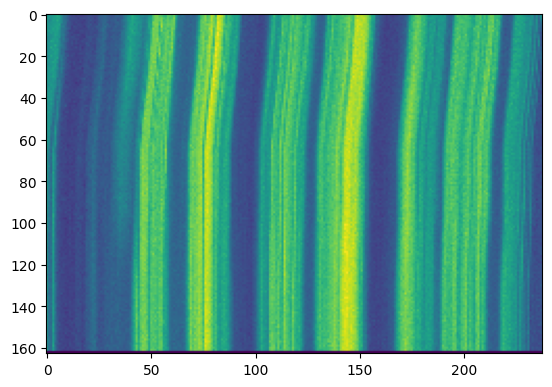

In [14]:
plt.imshow(dataCropped[:][:][0])

In [7]:
highPct, medPct = 99, 95

# Apply median filter and threshold
threshHigh = np.percentile(dataCropped, highPct)
filteredData = median_filter(dataCropped, size=(3, 3, 3))
dataCropped[dataCropped > threshHigh] = filteredData[dataCropped > threshHigh]

# Update threshold and replace values above it with the median
threshHigh = np.percentile(dataCropped, highPct)
dataCropped[dataCropped > threshHigh] = np.mean(np.percentile(dataCropped, medPct))


In [8]:
# Create mean column array
meanPerCol = np.mean(dataCropped,axis=(1,2))
meanCenterRow = meanPerCol[math.floor(cR/2)]
scales = meanCenterRow/meanPerCol

# Normalize
dataColNorm = dataCropped*scales[:, np.newaxis, np.newaxis]
dataNorm = np.clip(exposure.rescale_intensity(dataColNorm, in_range='image', out_range=(0,1)), 0, 1)

# Sharpen
blurred = gaussian_filter(dataNorm, sigma=3)
strength = 0.2
dataSharp = np.clip(dataNorm + strength * blurred, 0, 1)

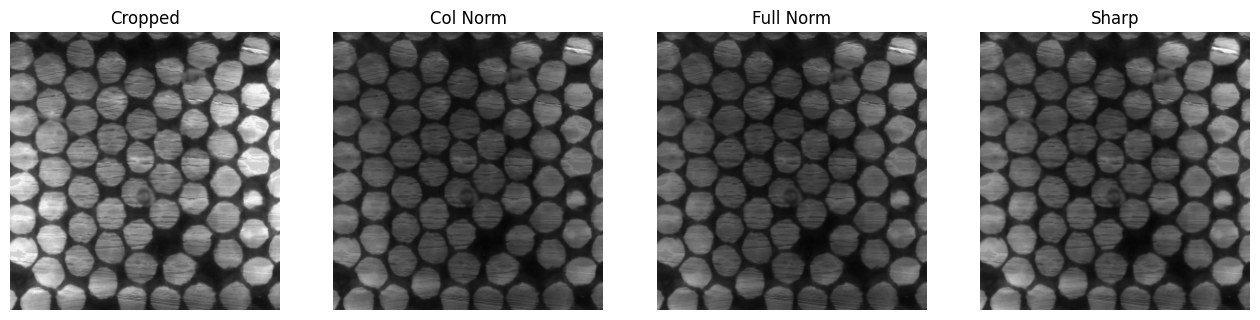

In [9]:
# Plot process
fig, axs = plt.subplots(1, 4, figsize=(16, 4)) 
ax1, ax2, ax3, ax4 = axs.flatten()

ax1.imshow(dataCropped[:, :, math.floor(cZ/2)], cmap='gray')
ax2.imshow(dataColNorm[:, :, math.floor(cZ/2)], cmap='gray')
ax3.imshow(dataNorm[:, :, math.floor(cZ/2)], cmap='gray')
ax4.imshow(dataSharp[:, :, math.floor(cZ/2)], cmap='gray')

ax1.set_title('Cropped')
ax2.set_title('Col Norm')
ax3.set_title('Full Norm')
ax4.set_title('Sharp')

for ax in axs:
    ax.axis('off')

plt.show()

In [10]:
# Download processed data
data = dataSharp
with h5py.File('processed_162.hdf5', 'w') as f: 
    dset = f.create_dataset("default", data)

TypeError: Can't convert element 0 ([[0.46672209 0.45069055 0.4252093  ... 0.09442214 0.10449593 0.08928578]
 [0.45518601 0.43481745 0.38548005 ... 0.09443187 0.09438723 0.10448235]
 [0.44729169 0.4110191  0.40939875 ... 0.07423368 0.07419468 0.08429331]
 ...
 [0.70405054 0.59908092 0.60803035 ... 0.49726968 0.45894204 0.44303319]
 [0.74515036 0.57298085 0.59500228 ... 0.45428305 0.46656376 0.47812836]
 [0.71110486 0.59245302 0.56245383 ... 0.47000705 0.4815661  0.50108415]]) to hsize_t